In [ ]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from dysts.metrics import compute_metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from panda.chronos.pipeline import ChronosPipeline
from panda.patchtst.pipeline import PatchTSTPipeline
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../config/plotting.yaml")

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WORK = os.environ.get("WORK", "")
base_dir = f"{WORK}/physics-datasets"
re = 450
fpath = f"{base_dir}/von_karman_street/vortex_street_velocities_Re_{re}_4800timepoints.npz"

In [3]:
figs_save_dir = "../figures/vonkarman"
os.makedirs(figs_save_dir, exist_ok=True)

In [4]:
vfield = np.load(fpath, allow_pickle=True)
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]
vort_field_flattened = vort_field.reshape(vort_field.shape[0], -1)

## Load Model Checkpoints

In [10]:
run_name = "pft_chattn_emb_w_poly-0"
# run_name = "pft_chattn_noembed_pretrained_correct-0"  # chattn + mlm
# run_name = "pft_linattnpolyemb_from_scratch-0"

pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path=f"/stor/work/Gilpin/checkpoints/{run_name}/checkpoint-final",
    device_map="cuda:2",
)

In [11]:
chronos_ft = ChronosPipeline.from_pretrained(
    # "/stor/work/AMDG_Gilpin_Summer2024/checkpoints/chronos_finetune_stand_updated-0/checkpoint-final",
    # "/stor/work/AMDG_Gilpin_Summer2024/checkpoints/chronos_mini_ft-0/checkpoint-final",
    "/stor/work/AMDG_Gilpin_Summer2024/checkpoints/chronos_t5_mini_ft-0/checkpoint-final",
    device_map="cuda:3",
    torch_dtype=torch.float32,
)

OSError: Incorrect path_or_model_id: '/stor/work/AMDG_Gilpin_Summer2024/checkpoints/chronos_t5_mini_ft-0/checkpoint-final'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [12]:
chronos_zs = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    device_map="cuda:4",
    torch_dtype=torch.float32,
)

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


AcceleratorError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Exploration and Utils

In [13]:
def plot_model_prediction(
    model,
    data: np.ndarray,
    context_length: int,
    prediction_length: int,
    title: str | None = None,
    show: bool = True,
    transpose: bool = True,
    indices: list[int] | None = None,
    **kwargs,
) -> np.ndarray:
    context = data[:, :context_length]
    groundtruth = data[:, context_length : context_length + prediction_length]
    context_tensor = torch.from_numpy(context.T if transpose else context).float()
    pred = model.predict(context_tensor, prediction_length, **kwargs).squeeze().cpu().numpy()
    if not transpose:
        pred = pred.T

    total_length = context.shape[1] + prediction_length
    context_ts = np.arange(context.shape[1]) / total_length
    pred_ts = np.arange(context.shape[1], total_length) / total_length

    if show:
        if indices is None:
            indices = [0, 1, 2]
        fig = plt.figure(figsize=(15, 4))

        outer_grid = fig.add_gridspec(1, 2, width_ratios=[0.5, 0.5], wspace=0.05)
        gs = outer_grid[1].subgridspec(3, 1, height_ratios=[1 / 3] * 3, wspace=0, hspace=0)
        ax_3d = fig.add_subplot(outer_grid[0], projection="3d")
        ax_3d.plot(*context[indices], alpha=0.5, color="black", label="Context")
        ax_3d.plot(*groundtruth[indices], linestyle="--", color="black", label="Groundtruth")
        ax_3d.plot(*pred.T[indices], color="red", label="Prediction")
        ax_3d.legend(loc="upper right", fontsize=12)
        ax_3d.set_xlabel("$x_{" + str(indices[0]) + "}$")
        ax_3d.set_ylabel("$x_{" + str(indices[1]) + "}$")
        ax_3d.set_zlabel("$x_{" + str(indices[2]) + "}$")
        if title is not None:
            ax_3d.set_title(title)

        axes_1d = [fig.add_subplot(gs[i, 0]) for i in range(3)]
        for i, ax in zip(indices, axes_1d):
            ax.plot(context_ts, context[i], alpha=0.5, color="black")
            ax.plot(pred_ts, groundtruth[i], linestyle="--", color="black")
            ax.plot(pred_ts, pred[:, i], color="red")
            index_str = "{" + str(i) + "}"
            ax.set_ylabel(f"$x_{index_str}$")
            ax.set_aspect("auto")
        axes_1d[-1].set_xlabel("Time")

        plt.show()

    return pred

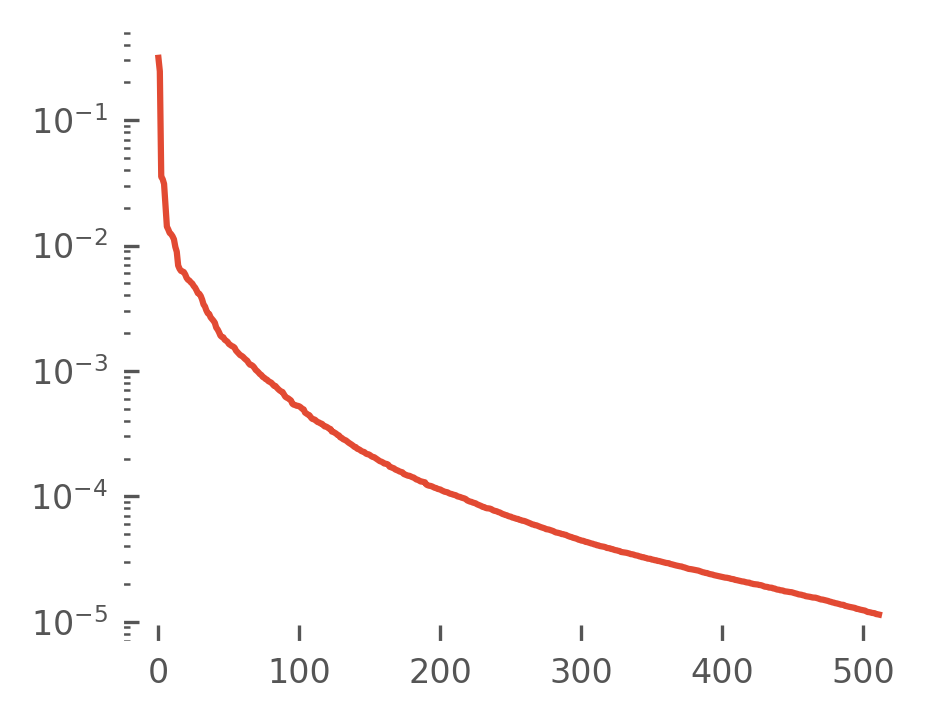

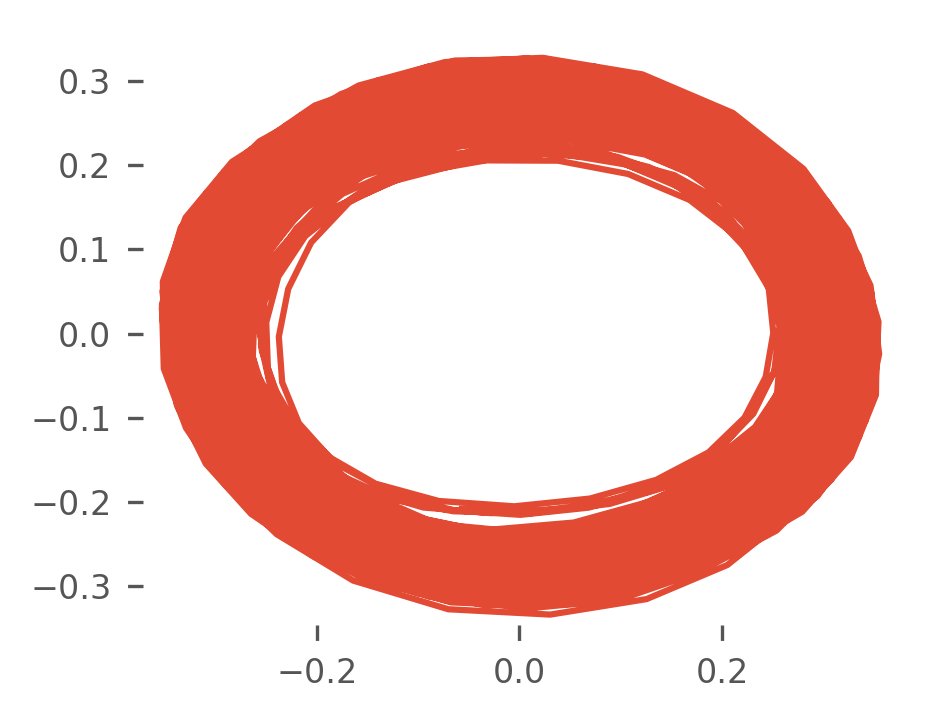

In [58]:
n_components = 512
pca = PCA(n_components=n_components)
pca.fit(vort_field_flattened)
X_ts = pca.transform(vort_field_flattened)  # (T, D)
eigenvectors = pca.components_  # (D, H*W)

## Show low-rank structure
plt.figure()
plt.plot(np.arange(n_components), pca.explained_variance_ratio_)
plt.semilogy()

## Plot trajectory
plt.figure()
plt.plot(X_ts[:, 0], X_ts[:, 1])

In [59]:
def reconstruct(pca_coeffs: np.ndarray, eigenvectors: np.ndarray, modes: int = -1) -> np.ndarray:
    if modes == -1:
        modes = pca_coeffs.shape[1]
    return pca_coeffs[:, :modes] @ eigenvectors[:modes, :]

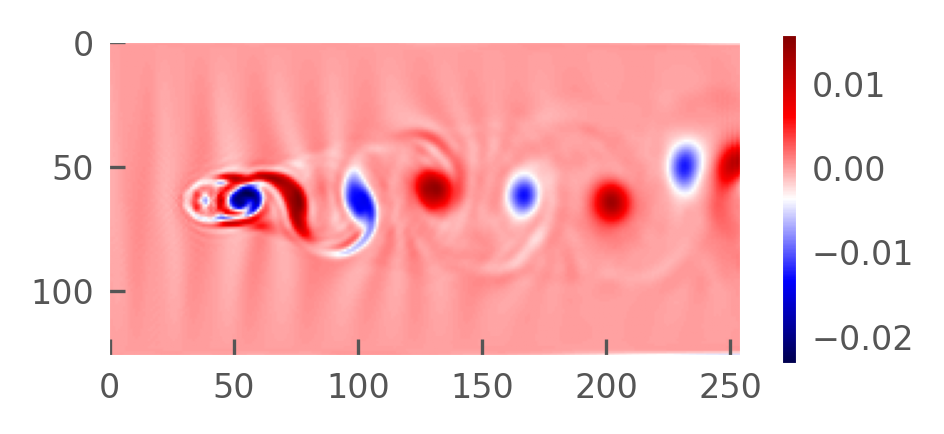

In [60]:
vort_recon = reconstruct(X_ts, eigenvectors)
vort_recon = vort_recon.reshape(vort_field.shape[0], vort_field.shape[1], vort_field.shape[2])
plt.figure()
plt.imshow(vort_recon[100 + 512, :, :].T, cmap="seismic")
plt.colorbar(shrink=0.5);

/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


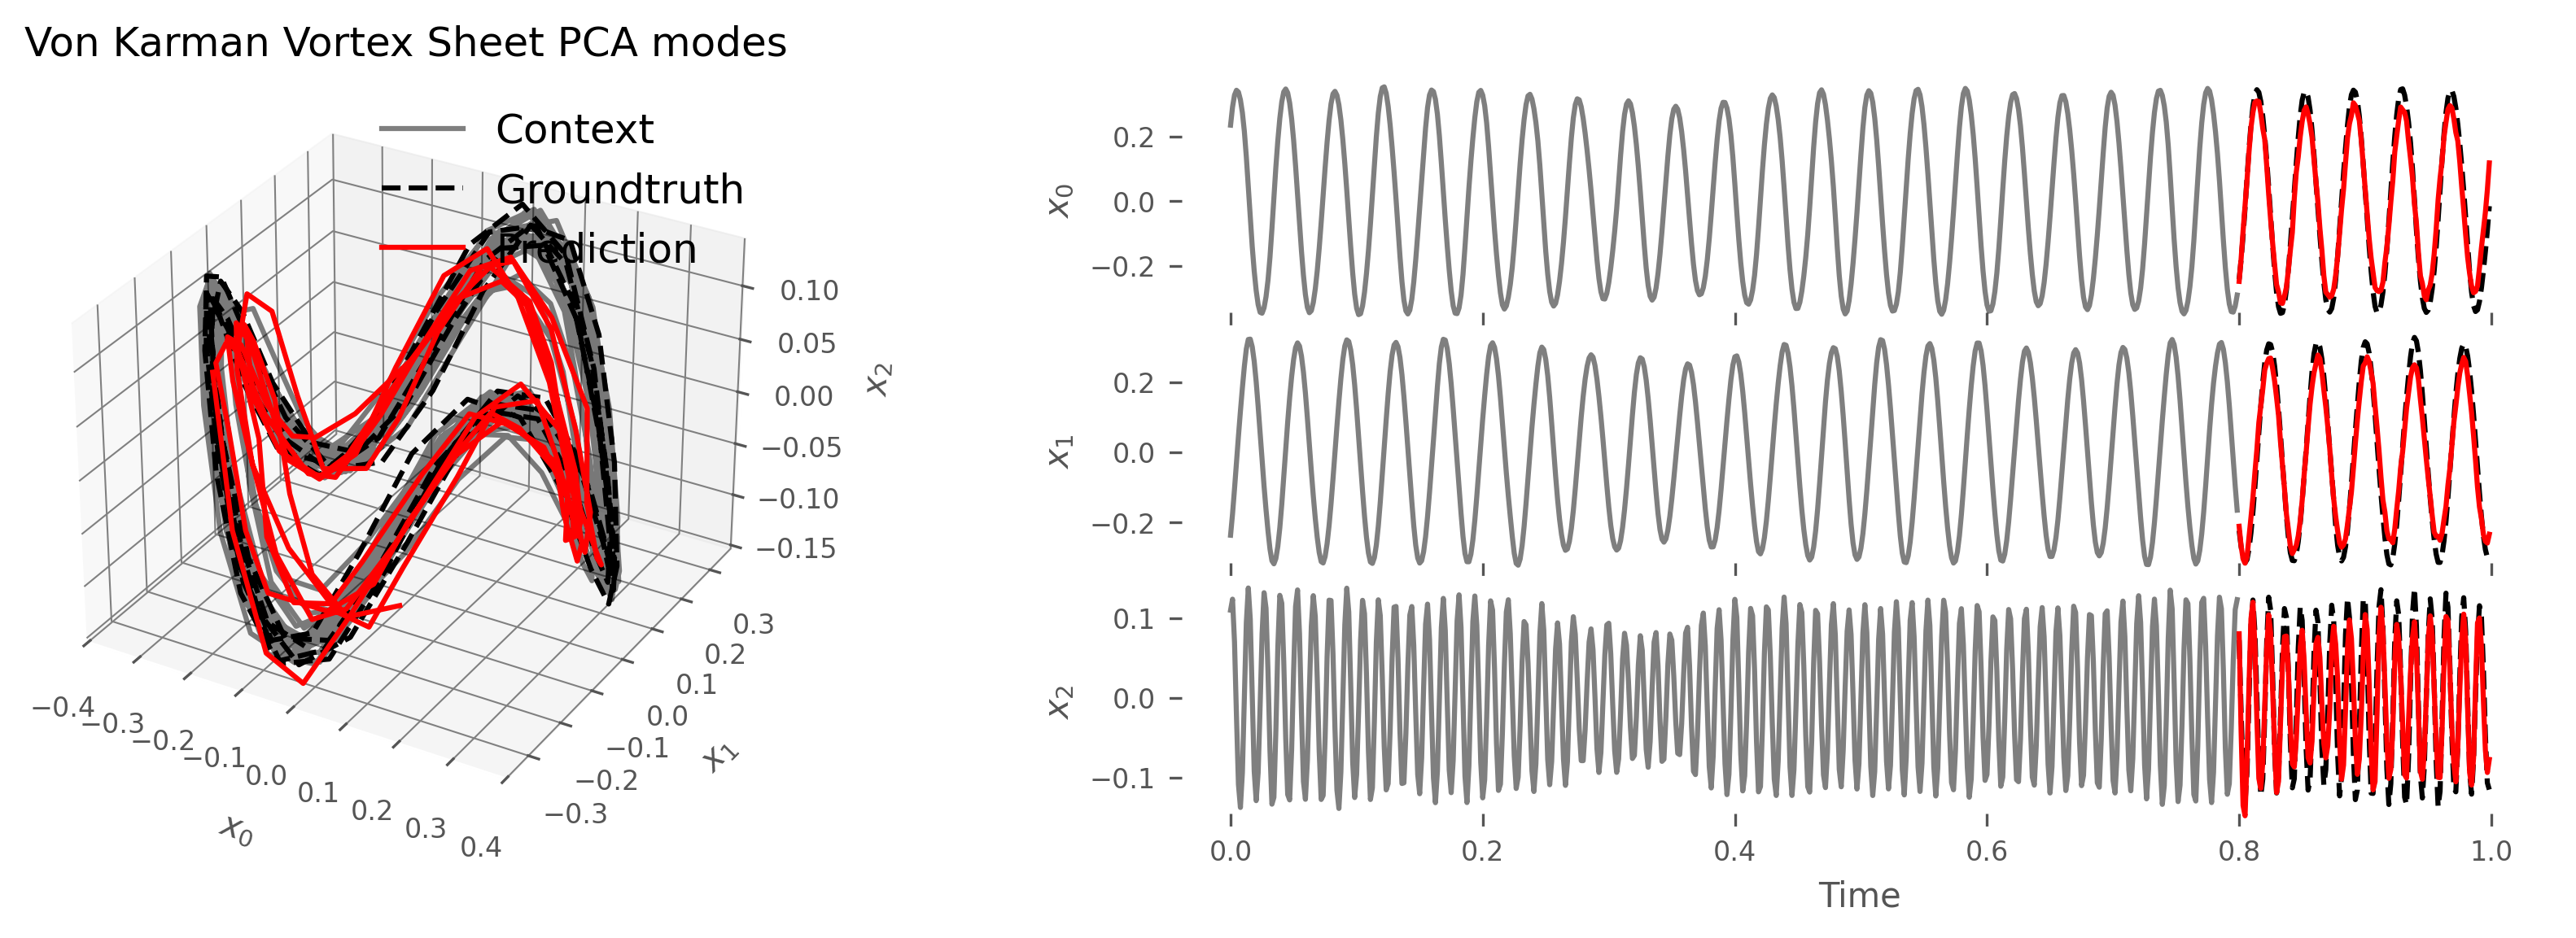

In [61]:
start = 2048  # ignore transient
stride = 1
subsampled_pca_coeffs = X_ts[start::stride, :]

predictions = plot_model_prediction(
    pft_model,
    subsampled_pca_coeffs.T,
    context_length=512,
    prediction_length=128,
    limit_prediction_length=False,
    sliding_context=True,
    title="Von Karman Vortex Sheet PCA modes",
    indices=[0, 1, 2],
)

## More Utils

In [62]:
def plot_predicted_flow(
    model,
    data,
    eigenvectors,
    context_length: int,
    prediction_length: int,
    num_modes: int,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    transpose: bool = False,
    batch_size: int | None = None,
    time_indices: list[int] | None = None,
    save_path: str | None = None,
    camera_ready: bool = False,
    cmap_name="seismic",
    base_figsize=(5, 5),
    suptitle: str | None = None,
    suptitle_y: float = 1.0,
    **kwargs,
):
    context = data[:context_length, :num_modes]
    groundtruth = data[context_length : context_length + prediction_length, :num_modes]

    torch.cuda.empty_cache()
    context_tensor = torch.from_numpy(context).float()

    if transpose:
        context_tensor = context_tensor.T

    if batch_size is None:
        pred = model.predict(context_tensor, prediction_length, **kwargs)
    else:
        pred = []
        for i in range(0, context_tensor.shape[0], batch_size):
            pred.append(model.predict(context_tensor[i : i + batch_size], prediction_length, **kwargs))
        pred = torch.cat(pred, dim=0)

    pred = pred.squeeze().detach().cpu().numpy()
    if transpose:
        pred = pred.T

    recon = reconstruct(pred, eigenvectors, modes=num_modes)
    recon = recon.reshape(prediction_length, shape[0], shape[1])
    groundtruth = reconstruct(groundtruth, eigenvectors, modes=num_modes)
    groundtruth = groundtruth.reshape(prediction_length, shape[0], shape[1])
    vabs = max(np.abs(groundtruth.min()), np.abs(groundtruth.max()))

    if time_indices is None:
        time_indices = list(range(0, prediction_length, stride))

    aspect_ratio = shape[0] / shape[1]
    fig = plt.figure(
        figsize=(
            base_figsize[0] * (len(time_indices)) / aspect_ratio,
            base_figsize[1] * aspect_ratio,
        )
    )
    gs = fig.add_gridspec(
        2,
        len(time_indices),
        width_ratios=[1] * (len(time_indices)),
        height_ratios=[1, 1],
        wspace=0,
        hspace=0,
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(len(time_indices))] for i in range(2)])
    for i, index in enumerate(time_indices):
        groundtruth_slice = groundtruth[index, :, :]
        recon_slice = recon[index, :, :]

        gax = axes[0, i].imshow(
            groundtruth_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )

        axes[0, i].spines["top"].set_visible(True)
        axes[0, i].spines["right"].set_visible(True)
        axes[0, i].spines["bottom"].set_visible(True)
        axes[0, i].spines["left"].set_visible(True)
        axes[0, i].spines["top"].set_color("black")
        axes[0, i].spines["right"].set_color("black")
        axes[0, i].spines["bottom"].set_color("black")
        axes[0, i].spines["left"].set_color("black")

        axes[0, i].set_title(
            # f"t={context_length}" + (f" + {index}" if index > 0 else ""),
            "t = context" + (f" + {index + 1}" if index > 0 else ""),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        rax = axes[1, i].imshow(
            recon_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )
        axes[1, i].spines["top"].set_visible(True)
        axes[1, i].spines["right"].set_visible(True)
        axes[1, i].spines["bottom"].set_visible(True)
        axes[1, i].spines["left"].set_visible(True)
        axes[1, i].spines["top"].set_color("black")
        axes[1, i].spines["right"].set_color("black")
        axes[1, i].spines["bottom"].set_color("black")
        axes[1, i].spines["left"].set_color("black")

        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[0, i].add_patch(circle)
        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[1, i].add_patch(circle)

    axes[0, 0].set_ylabel("Ground Truth", fontweight="bold", fontsize=16)
    axes[1, 0].set_ylabel("Predictions", fontweight="bold", fontsize=16)

    if suptitle is not None:
        plt.suptitle(suptitle, fontweight="bold", fontsize=18, ha="center", y=suptitle_y)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

In [63]:
def compute_rollout_metrics(
    model,
    data,
    eigenvectors,
    num_modes: int,
    context_length: int,
    prediction_length: int,
    time_interval: int = 64,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    transpose: bool = False,
    batch_size: int | None = None,
    compute_metrics_on_recons: bool = True,
    verbose: bool = False,
    **kwargs,
):
    context = data[:context_length, :num_modes]
    groundtruth = data[context_length : context_length + prediction_length, :num_modes]

    torch.cuda.empty_cache()
    context_tensor = torch.from_numpy(context).float()
    if transpose:
        context_tensor = context_tensor.T

    if batch_size is None:
        pred = model.predict(context_tensor, prediction_length, **kwargs)
    else:
        pred = []
        for i in range(0, context_tensor.shape[0], batch_size):
            pred.append(model.predict(context_tensor[i : i + batch_size], prediction_length, **kwargs))
        pred = torch.cat(pred, dim=0)

    pred = pred.squeeze().detach().cpu().numpy()
    if transpose:
        pred = pred.T

    rollout_time_intervals = np.arange(time_interval, prediction_length + time_interval, time_interval)

    metrics = {}
    if compute_metrics_on_recons:
        recon = reconstruct(pred, eigenvectors, modes=num_modes)
        recon = recon.reshape(prediction_length, shape[0], shape[1])
        groundtruth = reconstruct(groundtruth, eigenvectors, modes=num_modes)
        groundtruth = groundtruth.reshape(prediction_length, shape[0], shape[1])

        for t in rollout_time_intervals:
            metrics[t] = compute_metrics(recon[0:t], groundtruth[0:t], include=["mae", "mse", "smape"])
    else:
        if verbose:
            print(f"pred shape: {pred.shape}")
            print(f"groundtruth shape: {groundtruth.shape}")

        for t in rollout_time_intervals:
            metrics[t] = compute_metrics(pred[0:t], groundtruth[0:t], include=["mae", "mse", "smape"])

    return metrics

## Forecasts

In [64]:
stride = 1
start = 2048  # ignore transient
num_modes = 64
context_length = 512
prediction_length = 128
time_indices = [15, 31, 63, 127]

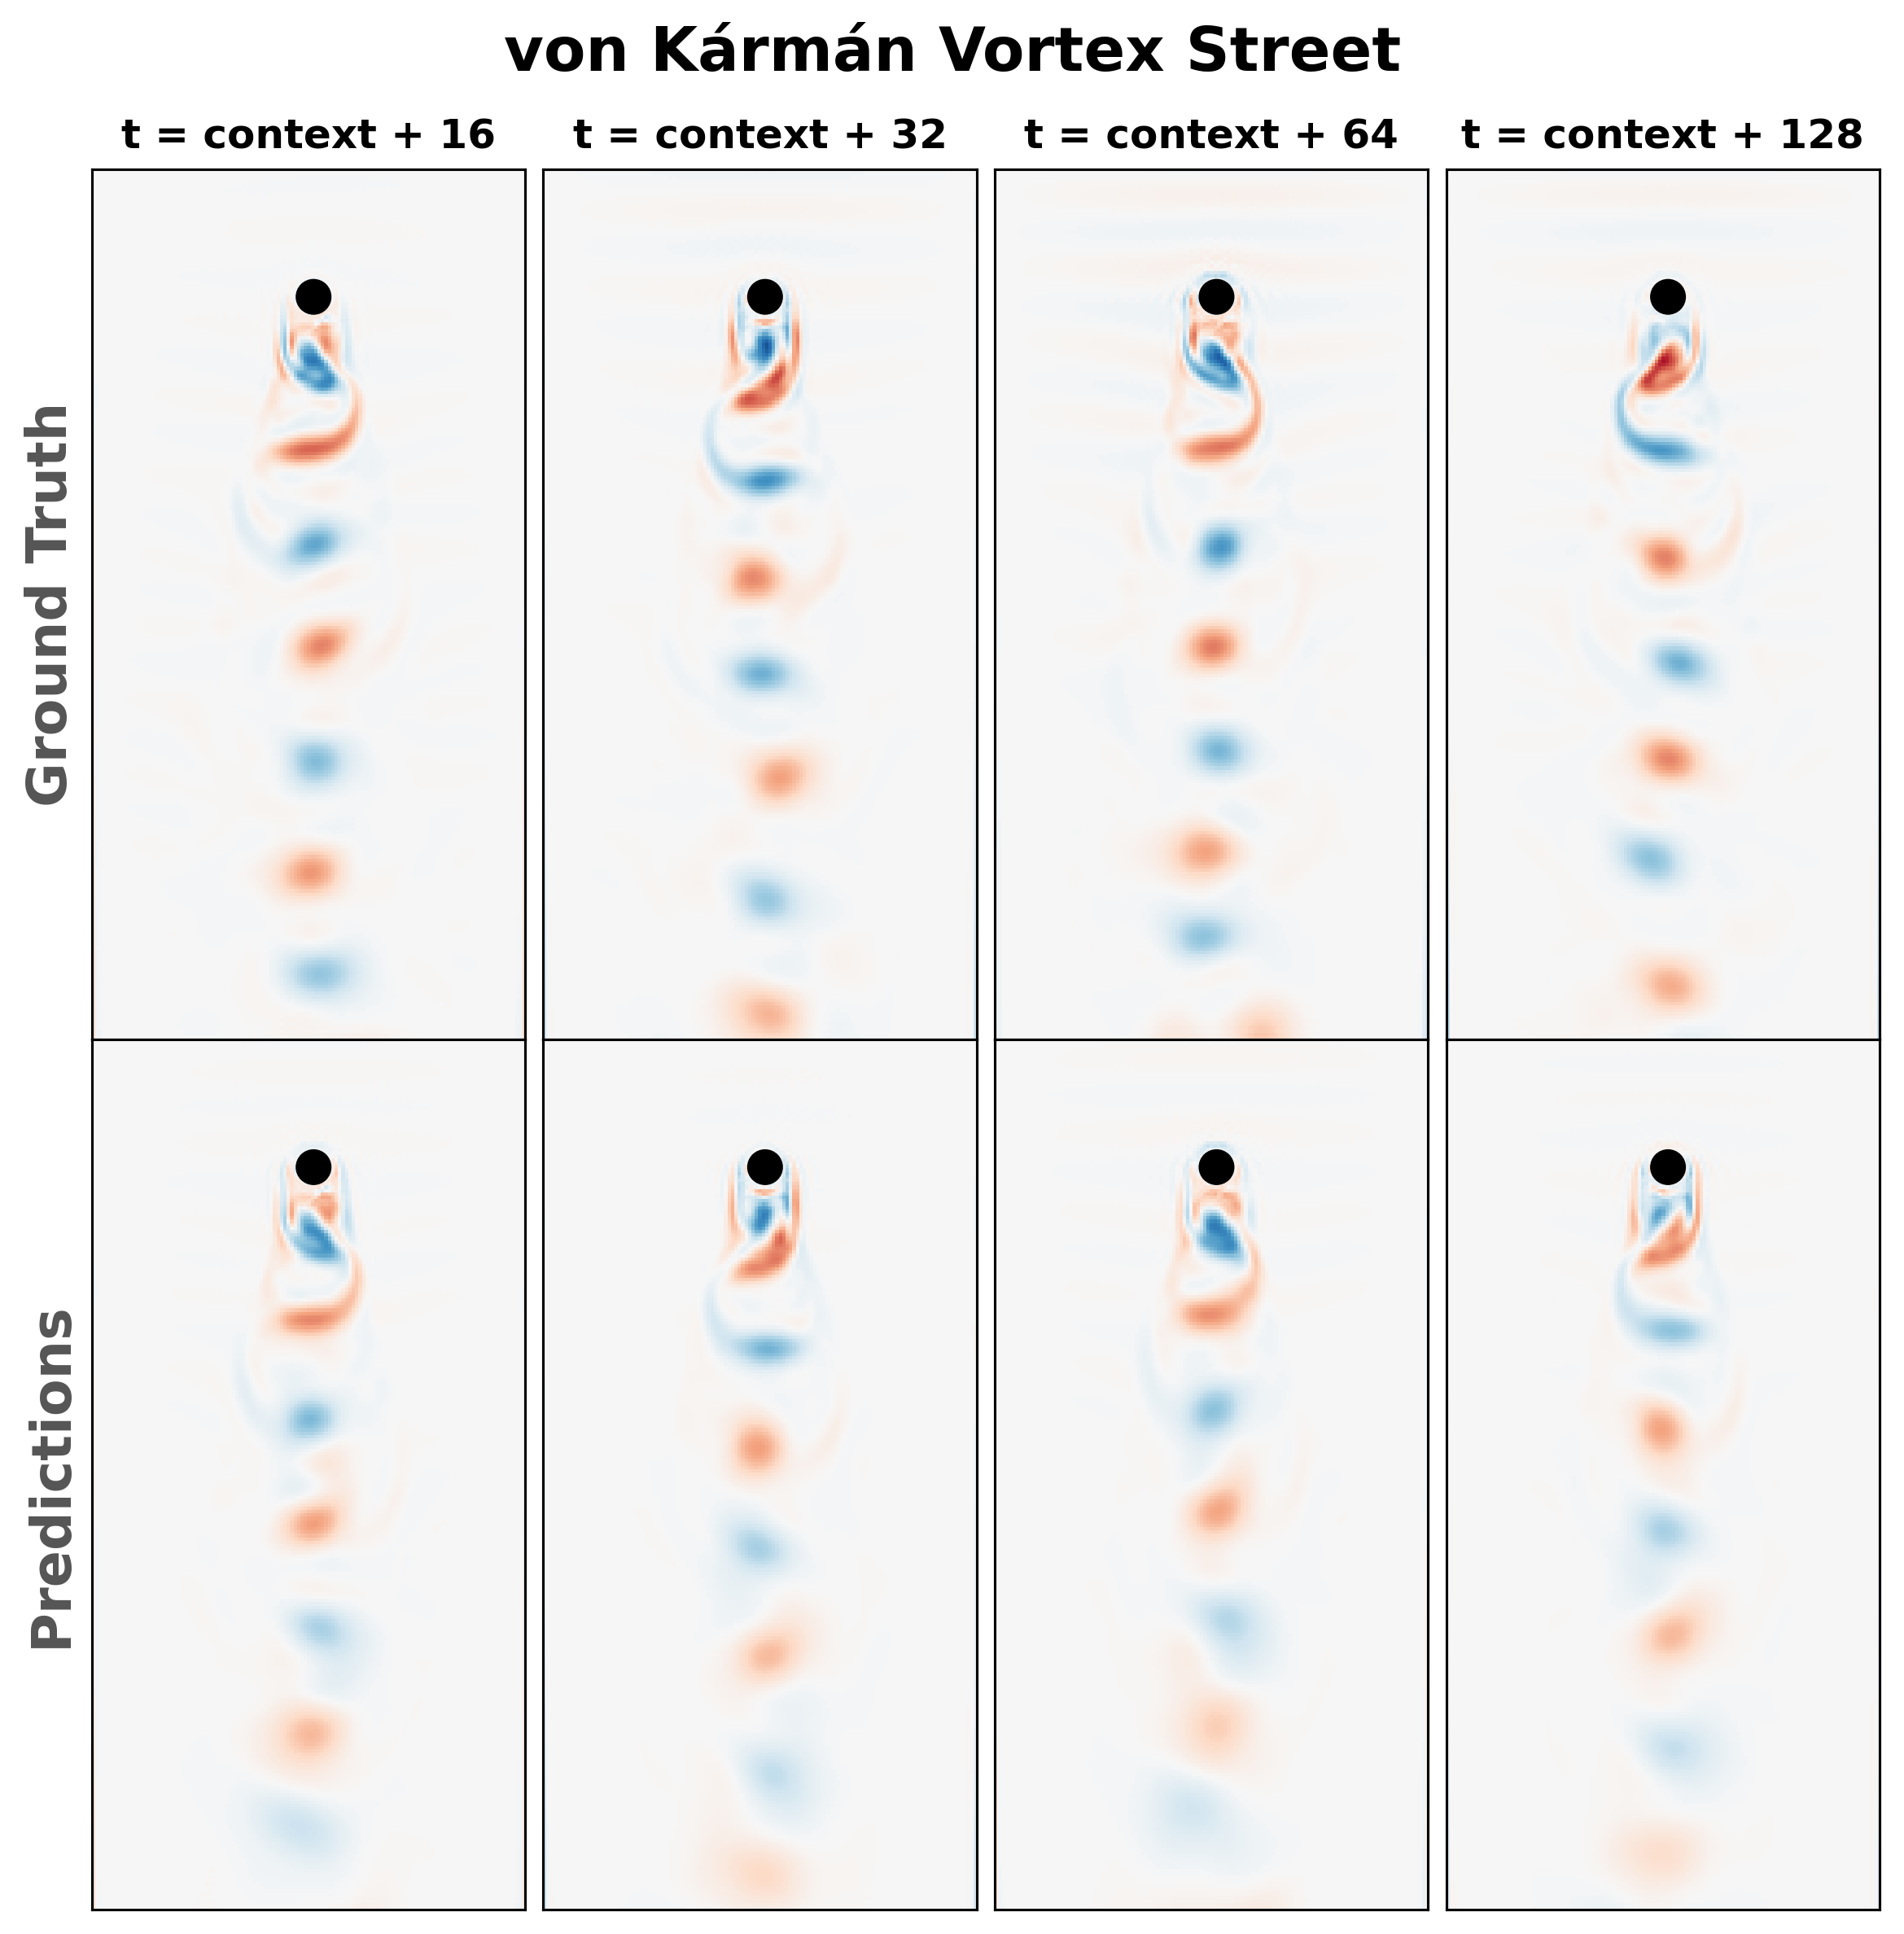

In [65]:
plot_predicted_flow(
    pft_model,
    X_ts[start::stride],
    eigenvectors,
    context_length=context_length,
    prediction_length=prediction_length,
    num_modes=num_modes,
    sliding_context=True,
    limit_prediction_length=False,
    time_indices=time_indices,
    cmap_name="RdBu",
    camera_ready=False,
    base_figsize=(4, 4),
    save_path=os.path.join(figs_save_dir, "von_karman_our_model.pdf"),
    suptitle="von Kármán Vortex Street",
    suptitle_y=0.98,
)

In [ ]:
plot_predicted_flow(
    chronos_ft,
    X_ts[start::stride],
    eigenvectors,
    context_length=context_length,
    prediction_length=prediction_length,
    num_modes=num_modes,
    batch_size=100,
    transpose=True,
    limit_prediction_length=False,
    num_samples=1,
    time_indices=time_indices,
    cmap_name="RdBu",
    camera_ready=False,
    save_path=os.path.join(figs_save_dir, "von_karman_chronos_ft.pdf"),
    suptitle="Chronos Finetune",
    deterministic=True,
)

In [ ]:
plot_predicted_flow(
    chronos_zs,
    X_ts[start::stride],
    eigenvectors,
    context_length=context_length,
    prediction_length=prediction_length,
    num_modes=num_modes,
    batch_size=100,
    transpose=True,
    limit_prediction_length=False,
    num_samples=1,
    time_indices=time_indices,
    cmap_name="RdBu",
    camera_ready=False,
    save_path=os.path.join(figs_save_dir, "von_karman_chronos_zs.pdf"),
    suptitle="Chronos ZS",
    deterministic=True,
)

## Metrics

In [66]:
compute_metrics_on_recons = True
use_chronos_deterministic = True

In [67]:
metrics = compute_rollout_metrics(
    pft_model,
    X_ts[start::stride],
    eigenvectors,
    num_modes=num_modes,
    context_length=context_length,
    prediction_length=512,
    time_interval=64,
    sliding_context=True,
    limit_prediction_length=False,
    compute_metrics_on_recons=compute_metrics_on_recons,
)
smape_metrics = {t: metrics[t]["smape"] for t in metrics.keys()}

/stor/home/jl82436/panda/panda/patchtst/pipeline.py:110: UserWarning: We recommend keeping prediction length <= 128. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [ ]:
metrics_chronos_ft = compute_rollout_metrics(
    chronos_ft,
    X_ts[start::stride],
    eigenvectors,
    num_modes=num_modes,
    context_length=context_length,
    prediction_length=512,
    time_interval=64,
    batch_size=100,
    transpose=True,
    limit_prediction_length=False,
    num_samples=1,
    compute_metrics_on_recons=compute_metrics_on_recons,
    deterministic=use_chronos_deterministic,
)
smape_metrics_chronos_ft = {t: metrics_chronos_ft[t]["smape"] for t in metrics_chronos_ft.keys()}

In [ ]:
metrics_chronos_zs = compute_rollout_metrics(
    chronos_zs,
    X_ts[start::stride],
    eigenvectors,
    num_modes=num_modes,
    context_length=context_length,
    prediction_length=512,
    time_interval=64,
    batch_size=100,
    transpose=True,
    limit_prediction_length=False,
    num_samples=1,
    compute_metrics_on_recons=compute_metrics_on_recons,
    deterministic=use_chronos_deterministic,
)
smape_metrics_chronos_zs = {t: metrics_chronos_zs[t]["smape"] for t in metrics_chronos_zs.keys()}

## Metrics across multiple runs

In [68]:
# random uniform sample start_times in interval [512, 3072]
n_runs = 10
# rseed = 1234
# rng = np.random.default_rng(rseed)
# start_times = np.random.choice(start_times, size=n_runs, replace=False)
start_times = np.arange(512, 3072, 256)
start_times = start_times.astype(int)
print(f"{len(start_times)} start_times: {start_times}")

10 start_times: [ 512  768 1024 1280 1536 1792 2048 2304 2560 2816]


In [69]:
# dict with keys as times t and values as list of smape values for each run
our_model_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    metrics = compute_rollout_metrics(
        pft_model,
        X_ts[start_time::stride],
        eigenvectors,
        num_modes=num_modes,
        context_length=context_length,
        prediction_length=512,
        time_interval=64,
        sliding_context=True,
        limit_prediction_length=False,
        verbose=False,
    )
    for t, metric in metrics.items():
        for metric_name, metric_val in metric.items():
            if t not in our_model_rollout_metrics[metric_name]:
                our_model_rollout_metrics[metric_name][t] = []
            our_model_rollout_metrics[metric_name][t].append(metric_val)

Running rollouts: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


In [ ]:
# dict with keys as times t and values as list of smape values for each run
chronos_ft_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    metrics_chronos_ft = compute_rollout_metrics(
        chronos_ft,
        X_ts[start_time::stride],
        eigenvectors,
        num_modes=num_modes,
        context_length=context_length,
        prediction_length=512,
        time_interval=64,
        batch_size=100,
        transpose=True,
        limit_prediction_length=False,
        num_samples=1,
        deterministic=use_chronos_deterministic,
    )
    for t, metric in metrics_chronos_ft.items():
        for metric_name, metric_val in metric.items():
            if t not in chronos_ft_rollout_metrics[metric_name]:
                chronos_ft_rollout_metrics[metric_name][t] = []
            chronos_ft_rollout_metrics[metric_name][t].append(metric_val)

In [ ]:
# dict with keys as times t and values as list of smape values for each run
chronos_zs_rollout_metrics = defaultdict(dict)
for start_time in tqdm(start_times, desc="Running rollouts"):
    metrics_chronos_ft = compute_rollout_metrics(
        chronos_zs,
        X_ts[start_time::stride],
        eigenvectors,
        num_modes=num_modes,
        context_length=context_length,
        prediction_length=512,
        time_interval=64,
        batch_size=100,
        transpose=True,
        limit_prediction_length=False,
        num_samples=1,
        deterministic=use_chronos_deterministic,
    )
    for t, metric_dict in metrics_chronos_ft.items():
        for metric_name, metric_val in metric_dict.items():
            if t not in chronos_zs_rollout_metrics[metric_name]:
                chronos_zs_rollout_metrics[metric_name][t] = []
            chronos_zs_rollout_metrics[metric_name][t].append(metric_val)

In [ ]:
# Calculate mean, standard deviation, and standard error for each model
def calculate_stats(data_dict):
    mean_vals = {t: np.mean(v) for t, v in data_dict.items()}
    median_vals = {t: np.median(v) for t, v in data_dict.items()}
    std_vals = {t: np.std(v) for t, v in data_dict.items()}
    ste_vals = {t: std_vals[t] / np.sqrt(len(data_dict[t])) for t in data_dict.keys()}
    return mean_vals, median_vals, std_vals, ste_vals


# Helper function to plot a model's results with error bands
def plot_model_results(mean_dict, ste_dict, marker, label):
    x_values = list(mean_dict.keys())
    y_values = list(mean_dict.values())
    y_errors = list(ste_dict.values())

    plt.plot(x_values, y_values, marker=marker, label=label)
    plt.fill_between(
        x_values,
        np.array(y_values) - np.array(y_errors),
        np.array(y_values) + np.array(y_errors),
        alpha=0.1,
    )

In [ ]:
metric_name = "mae"
metric_name_title = "MAE"
# Calculate statistics for all models
mean_metric_ours, median_metric_ours, _, ste_metric_ours = calculate_stats(our_model_rollout_metrics[metric_name])
mean_metric_chronos_ft, median_metric_chronos_ft, _, ste_metric_chronos_ft = calculate_stats(
    chronos_ft_rollout_metrics[metric_name]
)
mean_metric_chronos_zs, median_metric_chronos_zs, _, ste_metric_chronos_zs = calculate_stats(
    chronos_zs_rollout_metrics[metric_name]
)

# Create the plot
plt.figure(figsize=(4, 3))

# Plot each model
plot_model_results(mean_metric_ours, ste_metric_ours, "o", label="Panda")
plot_model_results(mean_metric_chronos_ft, ste_metric_chronos_ft, "s", label="Chronos 20M SFT")
plot_model_results(mean_metric_chronos_zs, ste_metric_chronos_zs, "v", label="Chronos 20M")

# Add labels and show
plt.xlabel("Prediction Length", fontweight="bold")
plt.xticks(list(mean_metric_ours.keys()))
plt.title("von Kármán Vortex Street", fontweight="bold")
plt.ylabel(metric_name_title, fontweight="bold")
# Set y-axis to use scientific notation
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.legend(loc="lower right", frameon=True, fontsize=7)
plt.tight_layout()
plt.savefig(
    os.path.join(figs_save_dir, f"vonkarman_all_models_{metric_name}.pdf"),
    bbox_inches="tight",
)
plt.show()

In [ ]:
metrics_combined = {
    "Panda": our_model_rollout_metrics,
    "Chronos 20M SFT": chronos_ft_rollout_metrics,
    "Chronos 20M": chronos_zs_rollout_metrics,
}

In [ ]:
import pickle

save_dir = "../outputs/vonkarman"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
with open(os.path.join(save_dir, "vonkarman_metrics_combined.pkl"), "wb") as f:
    pickle.dump(metrics_combined, f)